### Mounting your google drive on Colab Noetebook


In [ ]:
from google.colab import drive
## esto te va a pedir autorización. 
# Entra al link. Dale los permisos. Copiate el passw y pegalo acá donde te lo pide
drive.mount('/content/drive')

In [ ]:
## remplazá 'unqml'
# por el nombre que le hayas puesto a esa carpeta en drive si usaste otro distinto
%cd drive/My Drive/unqml/ML_UNQ2020/ 

In [ ]:
#%cd ../

In [2]:
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy.stats import norm
from matplotlib import pyplot as plt
import matplotlib

import scipy.stats as st

%load_ext rpy2.ipython

In [3]:
## Notar que los intervalos no dependen de n+m, sinó solo de n, el número de elementos positivos.

def ci_pr(aucpr,npos,alpha=0.05,method = "binomial"):
    z= norm.ppf(q=1-alpha/2,loc=0,scale=1)
    if method == "binomial":
        delta = z * np.sqrt(aucpr*(1-aucpr)/(npos))  ## es sobre n1, el número de elementos en la clase positiva (ver paper Kendrick, sección 3.2)
        lower = aucpr - delta
        upper = aucpr + delta
        return(lower, upper)
    elif method == 'logit':
        neta = np.log(aucpr/(1-aucpr)) # logit tranformation
        #tau (s.e.(neta))
        tau = 1/np.sqrt(npos*aucpr*(1-aucpr))

        delta_logit_scale = z*tau
        lower_logit_scale = neta-delta_logit_scale
        upper_logit_scale = neta+delta_logit_scale
        
        lower = np.exp(lower_logit_scale)/(1+np.exp(lower_logit_scale))
        upper = np.exp(upper_logit_scale)/(1+np.exp(upper_logit_scale))
        return lower, upper
    else: 
        print('method must be any of biomial or logit')
        



In [5]:
print(ci_pr(aucpr=0.95,npos=20,method = 'binomial') )
print(ci_pr(aucpr=0.95,npos=20,method = 'logit') )

(0.8544831705972787, 1.0455168294027213)
(0.7177966416663006, 0.993003468273759)


## Para generar nuestros datasets de prueba vamos a Interfasear con R
#### 1ro: Porque R tiene un paquete muy piola para jugar con este tema
#### 2do :  Para ver un ejemplo de cómo interfasear

In [6]:
import rpy2.robjects as ro

ro.r('''
install.packages("precrec")
library(precrec)
create_samples <- create_sim_samples    ### podría haber definido una función arbitraria,
                                        #### pero sólo cargué al entorno global una función del paquete precrec
''')
create_samples = ro.globalenv['create_samples']

In [7]:
num_predictores = 2
npos=5
nneg=10
tipo_de_muestra = "good_er"  ## Que significa good early retrieval (performance). 
# básicamente con el good_er le estoy diciendo que me arme un modelito que arranque con buenas predicciones iniciales

res= create_samples(num_predictores, npos, nneg, tipo_de_muestra)   
## Pará la pelota. Mirá lo que hicimos: 
## llamamos a una función de R, con objetos de python!!
res.names

'scores','labels','modnames','dsids'


#####  veamos que pnta tiene el objeto que generamos

In [8]:
scores = res.rx('scores')  ## rx permite obtener el objeto por nombre
print(scores)

labels = res.rx('labels')  ## rx permite obtener el objeto por nombre
print(labels)

$scores
$scores[[1]]
$scores[[1]][[1]]
 [1] 0.14059372 0.46026088 0.77802318 0.15725682 0.97544428 0.03385342
 [7] 0.50796298 0.00212678 0.01487502 0.13342541 0.04325594 0.07424148
[13] 0.10657494 0.30118885 0.30883233


$scores[[2]]
$scores[[2]][[1]]
 [1] 0.408604209 0.908371405 0.673260940 0.210989171 0.169719206 0.057433069
 [7] 0.460340550 0.220141214 0.041918285 0.429304966 0.004167898 0.032915605
[13] 0.346252395 0.074517796 0.328232600




$labels
 [1] 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0




In [9]:
ro.r('''
set.seed(31416)
library(precrec)
create_samples <- create_sim_samples    ### podría haber definido una función arbitraria,
                                        #### pero sólo cargué al entorno global una función del paquete precrec
''')
create_samples = ro.globalenv['create_samples']

def get_score_and_label(num_predictores = 2, npos=5, nneg=10, tipo_de_muestra = "good_er"):
    # llamo a la función desde R
    res= create_samples(num_predictores, npos, nneg, tipo_de_muestra)
    
    scores = list()  # lista de scores (tanto como predictores pida generar)
    for i in range(num_predictores):
        scores.append(np.array(res.rx('scores')[0][i][0]))
    
    labels= np.array(res.rx('labels')[0]).astype(int)
    return(scores,labels)

In [10]:
numpred=2;npos=200;nneg=400;tipo = 'good_er'
scores,labels = get_score_and_label(num_predictores = numpred, npos=npos, nneg=nneg, tipo_de_muestra = tipo)
aucpr0 = metrics.average_precision_score(y_true=labels,y_score = scores[0])
aucpr1 = metrics.average_precision_score(y_true=labels,y_score = scores[1])
aucpr0,aucpr1

(0.7643109450633458, 0.7275909252540539)

### Veamos ICs

In [11]:
print(ci_pr(aucpr0,npos=npos,alpha=0.05,method = "logit"))
print(ci_pr(aucpr1,npos=npos,alpha=0.05,method = "logit"))


(0.7005519078729424, 0.8180207872060191)
(0.6617571258319952, 0.7847784969815758)


In [12]:
prec0, rec0 , _ = metrics.precision_recall_curve(
        y_true=labels,
    probas_pred = scores[0])
prec1, rec1 , _ = metrics.precision_recall_curve(
        y_true=labels,
    probas_pred = scores[1])

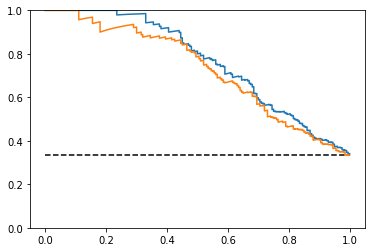

In [13]:
plt.plot(rec0,prec0)
plt.plot(rec1,prec1)
plt.ylim([0,1])
plt.hlines(npos/(npos+nneg), 0, 1, colors='k', linestyles='dashed')

## Juguemos un poquito más con R: 
(hay más cosas que valen la pena traer, aunque esta no sea necesariamente el caso)

In [ ]:
ro.r('''
install.packages("PRROC")
library(PRROC)
''')


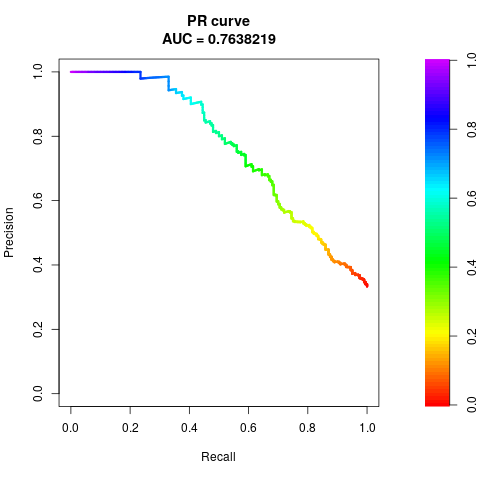

array([1], dtype=int32)

In [14]:

sc=scores[0]
%R -i sc -i labels plot(pr.curve(scores.class0 = sc, weights.class0 = labels, curve = TRUE))

## Notar que el AUCPR difiere del difiere del Calculado  en python
####  python usa
average_precision

#### PRROC usa un método de interpolación:
area under the curve computed using the interpolation of Davis & Goadrich (2006). 

# Veamos intervalos de confianza: 

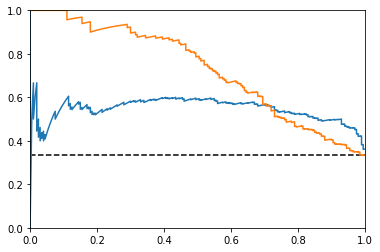

In [16]:
# sólo para fijar semilla y q todos sigamos viendo lo mismo
ro.r('''
set.seed(31416)
''')  

numpred=1;
npos=200;
nneg=400;
tipo = 'poor_er';
scores_poor, labels_poor = get_score_and_label(num_predictores = numpred, npos=npos, nneg=nneg, tipo_de_muestra = tipo)
#aucpr
aucpr_poor_er = metrics.average_precision_score(y_true=labels_poor,y_score = scores_poor[0])
# para plotear
prec_poor, rec_poor , _ = metrics.precision_recall_curve(
        y_true=labels_poor,
        probas_pred = scores_poor[0])




tipo = 'good_er';
scores_good, labels_good = get_score_and_label(num_predictores = numpred, npos=npos, nneg=nneg, tipo_de_muestra = tipo)
aucpr_good_er = metrics.average_precision_score(y_true=labels_good,y_score = scores_good[0])

# para plotear
prec_good, rec_good , _ = metrics.precision_recall_curve(
        y_true=labels_good,
        probas_pred = scores_good[0])



plt.plot(rec_poor,prec_poor)
plt.plot(rec_good,prec_good)
plt.ylim([0,1])
plt.xlim([0,1])
plt.hlines(npos/(npos+nneg), 0, 1, colors='k', linestyles='dashed')

In [17]:
low_poor, upper_poor = ci_pr(aucpr_poor_er,npos=npos,alpha=0.05,method = "logit")
low_good, upper_good = ci_pr(aucpr_good_er,npos=npos,alpha=0.05,method = "logit")

print('aucpr: %.2f'%aucpr_poor_er, "IC95%%: [%.2f %.2f]"%(low_poor,upper_poor))
print('aucpr: %.2f'%aucpr_good_er, "IC95%%: [%.2f %.2f]"%(low_good,upper_good))
# Los intervalos de confianza no se superponen

aucpr: 0.55 IC95%: [0.48 0.62]
aucpr: 0.73 IC95%: [0.66 0.78]


## De estos dos predictores podemos ver curvas ROC

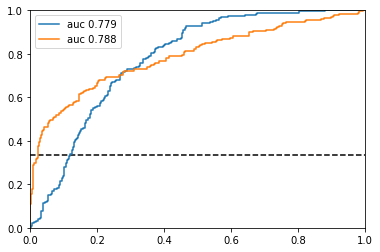

In [18]:
fpr_poor, tpr_poor , _ = metrics.roc_curve(
        y_true=labels_poor,
        y_score = scores_poor[0])

fpr_good, tpr_good , _ = metrics.roc_curve(
        y_true=labels_good,
        y_score = scores_good[0])

auc_poor = metrics.roc_auc_score(labels_poor,scores_poor[0])
auc_good = metrics.roc_auc_score(labels_good,scores_good[0])

plt.plot(fpr_poor,tpr_poor,label = 'auc %.3f'%auc_poor)
plt.plot(fpr_good,tpr_good,label = 'auc %.3f'%auc_good)
plt.ylim([0,1])
plt.xlim([0,1])
plt.hlines(npos/(npos+nneg), 0, 1, colors='k', linestyles='dashed')
plt.legend()


### Veamos cómo nos da el DeLong test

## R o python? Ambos!!

In [19]:
ro.r('''
install.packages("pROC")
library(pROC)
''')

sc_poor=scores_poor[0]
sc_good=scores_good[0]

%R -i sc_poor -i sc_good -i labels roc1 <- roc(response = labels,  predictor = sc_good); 
%R -i sc_poor -i sc_good -i labels roc2 <- roc(response = labels,  predictor = sc_poor)
%R delong <- roc.test(roc1, roc2,method="delong");
%R print(delong$estimate)
pv = %R delong$p.value
print("p-value =  %.3f"%pv)

R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:precrec’:

    auc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



AUC of roc1 AUC of roc2 
   0.788325    0.779100 
p-value =  0.749


# Veamos el AUC01

#### Calculemos las AUC-01 en python primero

In [20]:
ii = fpr_poor<=0.1
print('auc01 poor er: %.7f'%metrics.auc(fpr_poor[ii],tpr_poor[ii]))

jj = fpr_good<=0.1
print('auc01 poor er %.7f'%metrics.auc(fpr_good[jj],tpr_good[jj]))


auc01 poor er: 0.0116500
auc01 poor er 0.0425375


#### Ahora vamos a R, porque tiene implementado un test de bootstrap en una línea para testear dif signif

In [21]:
# le pido que haga el test limitando el FPR a 0.1, es decir la especificidad (sp) entre 1 y 0.9
# al evaluar AUC parciales, el test se hace por defecto vía boostraping. 

%R partial_auc_boostraping <- roc.test(roc1, roc2, reuse.auc=FALSE, partial.auc=c(1, 0.9), partial.auc.focus="sp")
%R print(partial_auc_boostraping$estimate)  # esto lo imprimo para que vean que son las mismas AUC las que estamos testeando
pv = %R partial_auc_boostraping$p.value
print("p-value =  %.3f"%pv)

  |======================================================================| 100%
pAUC (1-0.9 specificity) of roc1 pAUC (1-0.9 specificity) of roc2 
                       0.0425375                        0.0116500 
p-value =  0.000


## Puedo considerar la normalización de McClish 

#### El resultado del test no cambiará porque es una transformación lineal del AUC, una normalización que me ayuda a interpretar el valor de AUC parcial

$$AUC_{McClish} = \frac{1 + \frac{AUC - AUC_{rand}}{AUC_{max}-AUC_{rand}} }{2}$$

#### Por ejemplo, si tomamos AUC parcial a 
$$FPR = 0.1$$

tenremos: 

$$AUC_{max} = 0.1 $$ 
(área del rectángulo de base 0.1 y altura 1)



$$AUC_{rand} = 0.005 $$ 
(área del triángulo rectángulo de base 0.1 y altura 0.1)


In [22]:
# testeo metiendo la normalización de McClish
%R partial_auc_boostraping <- roc.test(roc1, roc2, reuse.auc=FALSE, partial.auc=c(1, 0.9), partial.auc.focus="sp",partial.auc.correct=TRUE)
%R print(partial_auc_boostraping$estimate)
pv = %R partial_auc_boostraping$p.value
print("p-value =  %.3f"%pv)


  |======================================================================| 100%
Corrected pAUC (1-0.9 specificity) of roc1 
                                 0.6975658 
Corrected pAUC (1-0.9 specificity) of roc2 
                                 0.5350000 
p-value =  0.000


#### Por completitud (es en realidad al dope), hagamos un test de AUC total pero no por deLong, sino por bootstrap

In [23]:
# No tiene sentido hacerlo por bootstrap si evalúo auc totales, pero sólo por completitud y para poder comparar
%R auc_boostraping <- roc.test(roc1, roc2,method = "bootstrap", boot.n=1000)  # notar que puedo controlar el número de iteraciones
%R print(auc_boostraping$estimate)
pvbtsp = %R auc_boostraping$p.value
print("p-value =  %.3f"%pvbtsp)

  |======================================================================| 100%
AUC of roc1 AUC of roc2 
   0.788325    0.779100 
p-value =  0.749


## Ejercicio: explorar el comportamiento de las curvas ROC y PR con distinto nivel de desbalance. 
#### Hacerlo para npos+nneg = 100000

In [24]:
nposs = np.array([10,50,100,500,1000,5000,10000,20000,30000,40000,50000])
nnegg = 10**5-nposs


In [25]:
# sólo para fijar semilla y q todos sigamos viendo lo mismo
ro.r('''
set.seed(31416)
''')  

AUC =[]
AUCPR=[]
PI = []
FPRs=[]
TPRs=[]
PRECs=[]
RECs=[]
numpred=1;
tipo = 'excel';
for i in range(len(nposs)):
    npos=int(nposs[i]);
    nneg=int(nnegg[i]);

    pii = npos/float(npos+nneg)
    scores, labels = get_score_and_label(num_predictores = numpred, npos=npos, nneg=nneg, tipo_de_muestra = tipo)

    prec, rec , _ = metrics.precision_recall_curve(
            y_true=labels,
            probas_pred = scores[0])

    fpr, tpr , _ = metrics.roc_curve(
            y_true=labels,
            y_score = scores[0])

    auc = metrics.auc(fpr,tpr)
    aucpr = metrics.average_precision_score(y_true=labels,y_score = scores[0])

    AUC.append(auc)
    AUCPR.append(aucpr)
    PI.append(pii)

    FPRs.append(fpr)
    TPRs.append(tpr)
    PRECs.append(prec)
    RECs.append(rec)


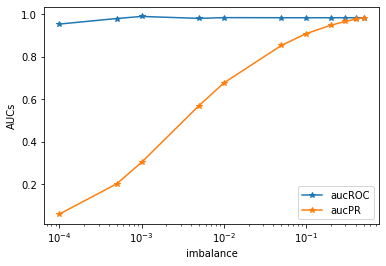

In [26]:
plt.plot(PI,AUC,'-*',label ='aucROC')
plt.plot(PI,AUCPR,'-*',label ='aucPR')
plt.xlabel('imbalance')
plt.ylabel('AUCs')
plt.legend()
plt.xscale('log')


## Veamos un ejemplo: 

0.001


Text(0, 0.5, 'Precision)')

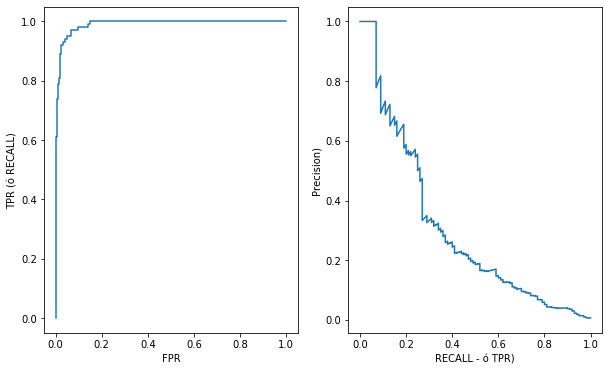

In [27]:
matplotlib.rcParams['figure.figsize'] = [10, 6]
i =2
pii = PI[i]
print(pii)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(FPRs[i] , TPRs[i])
ax1.set_xlabel('FPR')
ax1.set_ylabel('TPR (ó RECALL)')

ax2.plot(RECs[i], PRECs[i])
ax2.set_xlabel('RECALL - ó TPR)')
ax2.set_ylabel('Precision)')


## Parémonos en pi= 0.001, y veamos varios predictores


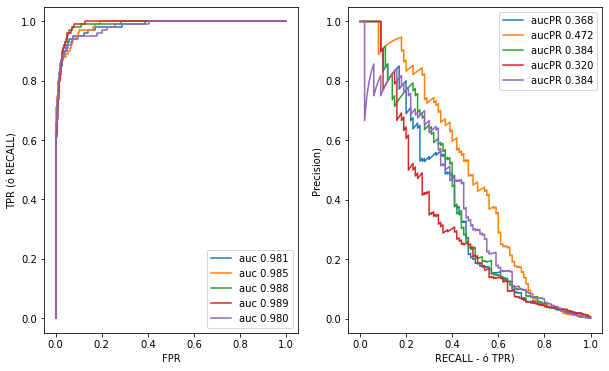

In [37]:
# sólo para fijar semilla y q todos sigamos viendo lo mismo
ro.r('''
set.seed(16180)
''')  


npos=100
nneg=10**5-npos
tipo = 'excel';
pii = npos/float(npos+nneg)
AUC =[]
AUCPR=[]
PI = []
FPRs=[]
TPRs=[]
PRECs=[]
RECs=[]
ntest = 5
for i in range(ntest):
    scores, labels = get_score_and_label(num_predictores = numpred, npos=npos, nneg=nneg, tipo_de_muestra = tipo)

    prec, rec , _ = metrics.precision_recall_curve(
            y_true=labels,
            probas_pred = scores[0])

    fpr, tpr , _ = metrics.roc_curve(
            y_true=labels,
            y_score = scores[0])

    auc = metrics.auc(fpr,tpr)
    aucpr = metrics.average_precision_score(y_true=labels,y_score = scores[0])
    AUC.append(auc)
    AUCPR.append(aucpr)
    PI.append(pii)

    FPRs.append(fpr)
    TPRs.append(tpr)
    PRECs.append(prec)
    RECs.append(rec)
    
    
matplotlib.rcParams['figure.figsize'] = [10, 6]
fig, (ax1, ax2) = plt.subplots(1, 2)
for i in range(ntest):
    pii = PI[i]

    ax1.plot(FPRs[i] , TPRs[i],label = 'auc %.3f'%AUC[i])
    ax1.set_xlabel('FPR')
    ax1.set_ylabel('TPR (ó RECALL)')

    ax2.plot(RECs[i], PRECs[i],label='aucPR %.3f'%AUCPR[i])
    ax2.set_xlabel('RECALL - (ó TPR)')
    ax2.set_ylabel('Precision)')
ax1.legend()
ax2.legend()

# Ejercicios propuestos para entretenerse :

#### 1)  tipo de clasificador generdo (random, poor_er, good_er, excel)
* Hacerlo en estas figuras con PI fijo
* Hacerlo en las anteriores barriendo PI.

#### 2) dejando fijo PI, y variando el número total de muestras npos+nneg  ~ entre 100 y 10**5 por ejemplo